In [49]:
import pandas as pd
import seaborn as sns
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'
cell = 'CD4'

#Data loading
df = pd.read_csv("../data/activation_scores/msigdb_activation_vst_"+cell+".csv", engine='c', index_col=0).T
df_expr = pd.read_csv("../data/counts_normalized/IDConvertedFiles/counts_vst_"+cell+".converted.csv", engine='c', index_col=0)
df_expr = df_expr.subtract(df_expr.median(axis=1), axis=0)
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv').set_index('HCVB_ID')


inter_samples = list(set(meta_data.index.tolist()).intersection(df_expr.columns.tolist()))
df_expr = df_expr[inter_samples]
df = df[inter_samples]
meta_data = meta_data.loc[inter_samples]
#meta_data = meta_data.loc[meta_data['HCVB_ID'].isin(df_expr.columns.tolist())]


In [50]:
df_cd4 = df.copy()
df_cd4 = df_cd4.subtract(df_cd4.median(axis=1), axis=0)

In [51]:
selected_pathways = ['RUNNE_GENDER_EFFECT_UP',
'PYEON_CANCER_HEAD_AND_NECK_VS_CERVICAL_DN',
'GSE5099_DAY3_VS_DAY7_MCSF_TREATED_MACROPHAGE_DN',
'GSE3982_MEMORY_CD4_TCELL_VS_BCELL_UP',
'GOMF_HISTONE_DEMETHYLASE_ACTIVITY_H3_K4_SPECIFIC',
'GOMF_PROTEIN_DEMETHYLASE_ACTIVITY',
'GOBP_HISTONE_H3_K4_DEMETHYLATION',
'HP_ABNORMAL_SPERMATOGENESIS',
'CARDOSO_RESPONSE_TO_GAMMA_RADIATION_AND_3AB',
'PGF_UP.V1_DN']

In [52]:
def _extract_geneSignature(actInput, msigDBPath):
    #Data loading
    df = actInput.copy() # activation score data for extracting gene signature

    # MsigDB Parsing
    gmt_arr = [] # gmt parsing array
    with open(msigDBPath, 'r') as infile:
        for line in infile:
            gmt_value = line.strip().split("\t") # splitting line
            sig_names = gmt_value[0] # signature name
            gene_list = gmt_value[2:] # gene list
            gmt_arr.append([sig_names]+gene_list)

    gmt_ext_arr = [x[1:] for x in gmt_arr if x[0] in df.index.tolist()] # Selected signature genes
    gmt_ext_arr = list(itertools.chain(*gmt_ext_arr))
    gmt_ext_arr = list(set(gmt_ext_arr)) # remove duplicated
    return gmt_ext_arr

genelist = _extract_geneSignature(df_cd4.loc[selected_pathways], '../data/MsigDB_list/msigdb.v7.4.entrez.gmt')


In [53]:
#df_expr.loc[genelist]
i_genelist = list(set(df_expr.index.tolist()).intersection(genelist))
df_expr = df_expr.loc[i_genelist]

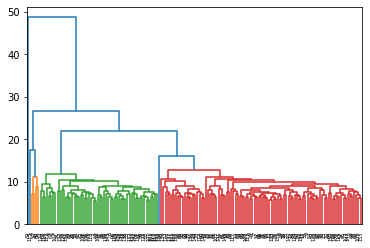

In [54]:
# Dendrogram generating
import scipy.cluster.hierarchy as hc
dendrogram = hc.dendrogram((hc.linkage(df_expr.T, method ='complete')), color_threshold=15)

cluster_arr = []
for idx, cluster in zip(dendrogram['ivl'], dendrogram['leaves_color_list']):
    cluster_arr.append([df_expr.T.index.tolist()[int(idx)], cluster])


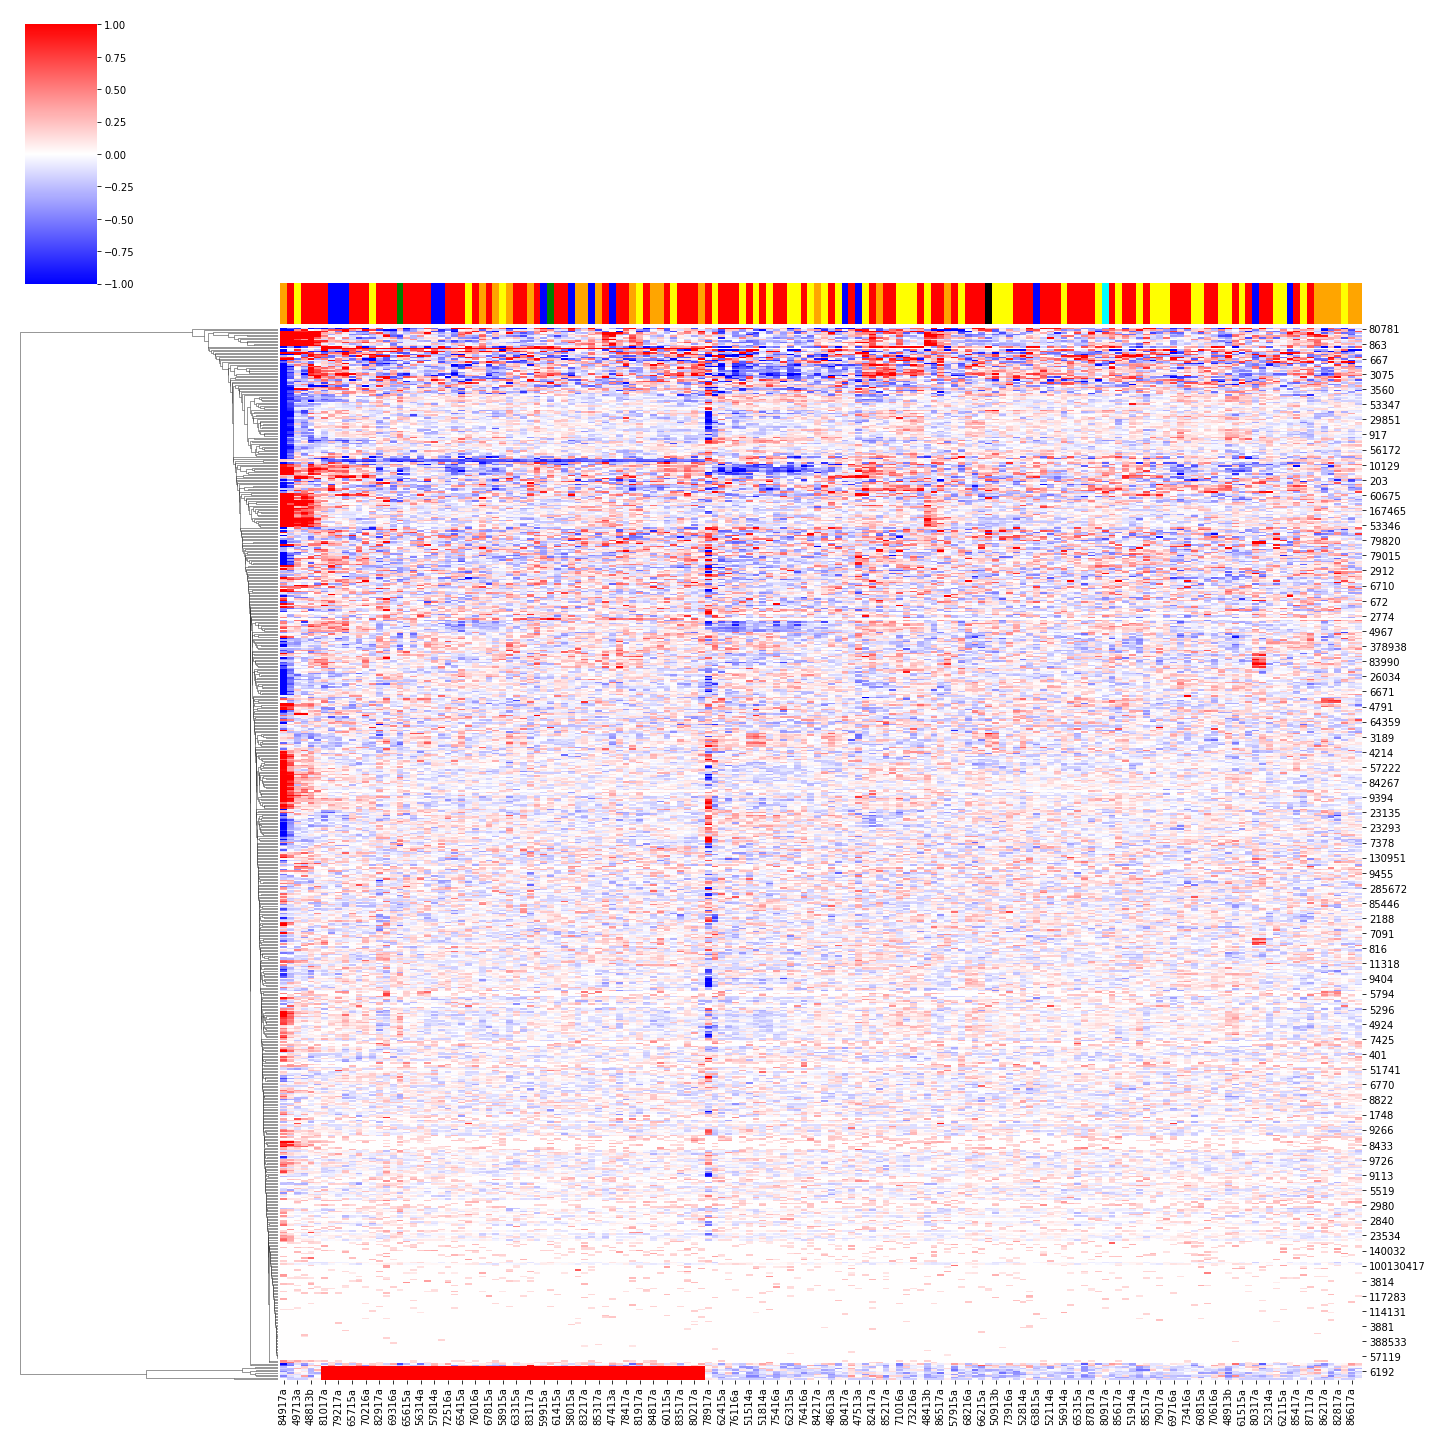

In [58]:
# Heatmap by dendrogram
c_sample_df = pd.DataFrame(data=cluster_arr, columns=['Sample', 'Cluster'])

lut_d = dict(zip(['RR', 'PP', 'SP', 'RIS', 'CIS', 'Unknown', 'Healthy'], ['red', 'blue', 'black', 'green', 'yellow', 'cyan', 'orange']))
dis_course = meta_data['DiseaseCourse'].loc[c_sample_df['Sample']].values.tolist()
cated_map = [lut_d[x] for x in dis_course]

lut_d = dict(zip(['M', 'F'], ['red', 'blue']))
sex_info = meta_data['Sex'].loc[c_sample_df['Sample']].values.tolist()
cated_mapx = [lut_d[x] for x in sex_info]

sns.clustermap(df_expr[c_sample_df['Sample']],col_colors=cated_map ,col_cluster=False, figsize=(20,20), cmap='bwr', vmin=-1, vmax=1)

In [63]:
meta_data[['Sex', 'DiseaseCourse']].groupby(['Sex','DiseaseCourse']).size()

Sex  DiseaseCourse
F    CIS              35
     Healthy          10
     PP                5
     RR               50
     SP                1
     Unknown           1
M    CIS               5
     Healthy          11
     PP                9
     RIS               2
     RR               29
dtype: int64

In [66]:
df_expr[c_sample_df['Sample']].to_csv('resultFiles/Sex_analysis_by_Jun/extracted_genes_expr.csv')